In [8]:
import pennylane as qml
from pennylane.templates.state_preparations.mottonen import compute_theta, gray_code
import numpy as np
import matplotlib.pyplot as plt

A = np.array([[-0.51192128, -0.51192128,  0.6237114 ,  0.6237114 ],
              [ 0.97041007,  0.97041007,  0.99999329,  0.99999329],
              [ 0.82429855,  0.82429855,  0.98175843,  0.98175843],
              [ 0.99675093,  0.99675093,  0.83514837,  0.83514837]])

In [9]:
alphas = np.arccos(A).flatten()
thetas = compute_theta(alphas)
thetas

array([0.58865313, 0.        , 0.        , 0.16998594, 0.23537376,
       0.        , 0.        , 0.36101237, 0.32848621, 0.        ,
       0.        , 0.00729926, 0.19279192, 0.        , 0.        ,
       0.22461361])

In [10]:
ancilla_wires = ["ancilla"]

s = int(np.log2(A.shape[0]))
wires_i = [f"i{index}" for index in range(s)]
wires_j = [f"j{index}" for index in range(s)]


In [11]:
code = gray_code(2 * np.log2(len(A)))
n_selections = len(code)

control_wires = [int(np.log2(int(code[i], 2) ^ int(code[(i + 1) %
                 n_selections], 2))) for i in range(n_selections)]

print(code)
print(len(control_wires))
print(control_wires)
wire_map = {control_index : wire for control_index, wire in enumerate(wires_j + wires_i)}


['0000', '0001', '0011', '0010', '0110', '0111', '0101', '0100', '1100', '1101', '1111', '1110', '1010', '1011', '1001', '1000']
16
[0, 1, 0, 2, 0, 1, 0, 3, 0, 1, 0, 2, 0, 1, 0, 3]


In [12]:
def UA(thetas, control_wires, ancilla):
    for theta, control_index in zip(thetas, control_wires):
        qml.RY(2 * theta, wires=ancilla)
        qml.CNOT(wires=[wire_map[control_index]] + ancilla)


def UB(wires_i, wires_j):
    for w_i, w_j in zip(wires_i, wires_j):
        qml.SWAP(wires=[w_i, w_j])


def HN(input_wires):
    for w in input_wires:
        qml.Hadamard(wires=w)


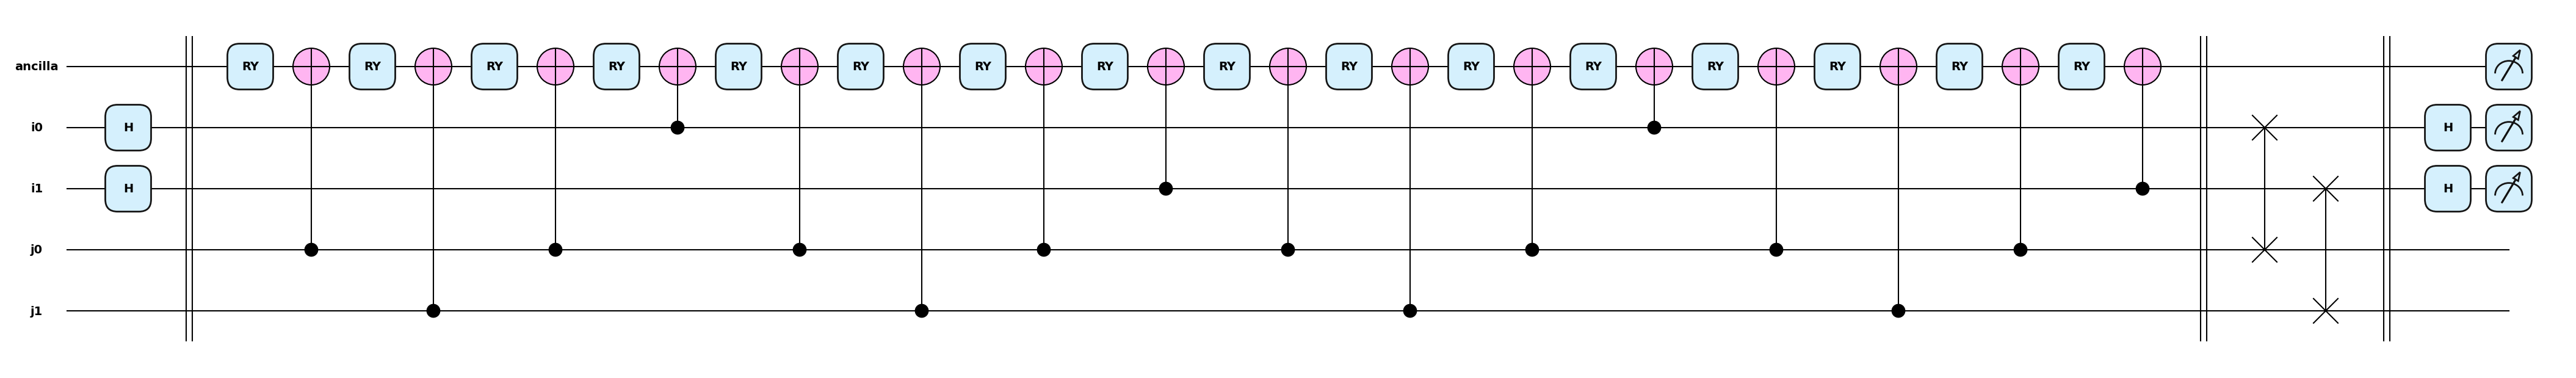

In [13]:
dev = qml.device('default.qubit', wires=ancilla_wires + wires_i + wires_j)
@qml.qnode(dev)
def circuit():
    HN(wires_i)
    qml.Barrier()  # to separate the sections in the circuit
    UA(thetas, control_wires, ancilla_wires)
    qml.Barrier()
    UB(wires_i, wires_j)
    qml.Barrier()
    HN(wires_i)
    return qml.probs(wires=ancilla_wires + wires_i)

qml.draw_mpl(circuit, style='pennylane')()
plt.show()


In [14]:
print(f"Original matrix:\n{A}", "\n")
wire_order = ancilla_wires + wires_i[::-1] + wires_j[::-1]
M = len(A) * qml.matrix(circuit, wire_order=wire_order)().real[0:len(A),0:len(A)]
print(f"Block-encoded matrix:\n{M}", "\n")


Original matrix:
[[-0.51192128 -0.51192128  0.6237114   0.6237114 ]
 [ 0.97041007  0.97041007  0.99999329  0.99999329]
 [ 0.82429855  0.82429855  0.98175843  0.98175843]
 [ 0.99675093  0.99675093  0.83514837  0.83514837]] 

Block-encoded matrix:
[[-0.51192128 -0.51192128  0.6237114   0.6237114 ]
 [ 0.97041007  0.97041007  0.99999329  0.99999329]
 [ 0.82429855  0.82429855  0.98175843  0.98175843]
 [ 0.99675093  0.99675093  0.83514837  0.83514837]] 

